In [4]:
import pickle
with open('full_data.pkl', 'rb') as f:
    df = pickle.load(f)
print(df.head())
print(len(df))

               time_posted               blog_name       post_id post_type  \
0  2018-03-13 01:24:50 GMT  hometown-helen-of-troy  171814404387     photo   
1  2018-03-13 01:24:25 GMT  hometown-helen-of-troy  171814392952     photo   
2  2018-02-27 05:49:52 GMT        prettyandpurple0  171335923889      text   
3  2018-02-04 13:08:35 GMT       dykemesticgoddess  170492840461      text   
4  2018-02-04 13:04:47 GMT       dykemesticgoddess  170492764641      text   

  image_urls                                               tags  \
0         []         [baking, homemaking, traditional, tradfem]   
1         []  [marilyn monroe, tradfem, traditional, feminin...   
2         []  [tradfem, traditional life, traditional, house...   
3         []  [domestblr, tradfem, housewife, housekeeping, ...   
4         []                    [domestblr, housewife, tradfem]   

                                            post_url  
0  https://hometown-helen-of-troy.tumblr.com/post...  
1  https://hometow

In [5]:
#getting tradwife "score" 
def get_tradwife_score(tags):
    return tags.count('tradwife')+tags.count('tradfem')+tags.count('tradblr')


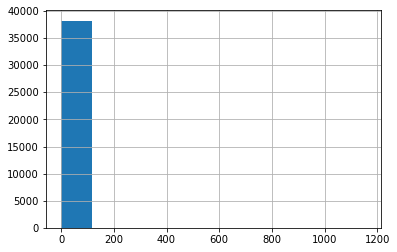

In [6]:
df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)
tradwifescores = df.groupby(by=["blog_name"])['tradwife_score'].sum()
import matplotlib.pyplot as plt
import numpy as np
tradwifescores.hist()
plt.show()
tradwifescores = np.log(tradwifescores, where=(tradwifescores!=0))
#looks like this measure would benefit from a log scale, will adjust spline on gephi

Graphing tradwife score over time

In [5]:
print(df.head())

               time_posted               blog_name       post_id post_type  \
0  2018-03-13 01:24:50 GMT  hometown-helen-of-troy  171814404387     photo   
1  2018-03-13 01:24:25 GMT  hometown-helen-of-troy  171814392952     photo   
2  2018-02-27 05:49:52 GMT        prettyandpurple0  171335923889      text   
3  2018-02-04 13:08:35 GMT       dykemesticgoddess  170492840461      text   
4  2018-02-04 13:04:47 GMT       dykemesticgoddess  170492764641      text   

  image_urls                                               tags  \
0         []         [baking, homemaking, traditional, tradfem]   
1         []  [marilyn monroe, tradfem, traditional, feminin...   
2         []  [tradfem, traditional life, traditional, house...   
3         []  [domestblr, tradfem, housewife, housekeeping, ...   
4         []                    [domestblr, housewife, tradfem]   

                                            post_url  tradwife_score  
0  https://hometown-helen-of-troy.tumblr.com/post...     

In [6]:
import pandas as pd
df['time_posted'] = pd.to_datetime(df.time_posted)
timeseriesdf = df.groupby([df.time_posted.dt.to_period('M'), 'blog_name']).sum('tradwife_score').reset_index()

c:\Users\melka\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [7]:
print(timeseriesdf.head())

  time_posted                  blog_name  tradwife_score
0     2015-08  oaesiir-beloved-of-heaven               3
1     2016-02                 baronzachm               1
2     2016-02  oaesiir-beloved-of-heaven               2
3     2016-06                 baronzachm               1
4     2016-06  oaesiir-beloved-of-heaven               1


In [8]:
timeseriesdf = timeseriesdf.pivot_table(index='time_posted',columns='blog_name',values='tradwife_score',aggfunc='sum').fillna(0)

In [11]:
user_differences = []
users = []
for user in timeseriesdf:
    difference = 0
    oldval = 0
    for val in timeseriesdf[user]:
        difference = difference + abs(oldval-val)
        oldval = val
    user_differences.append(difference)
    users.append(user)
relevant_users = []
for user, difference in zip(users, user_differences):
    if difference >0:
        relevant_users.append(user)

<AxesSubplot:title={'center':'Tradwife Score over Time'}, xlabel='time_posted'>

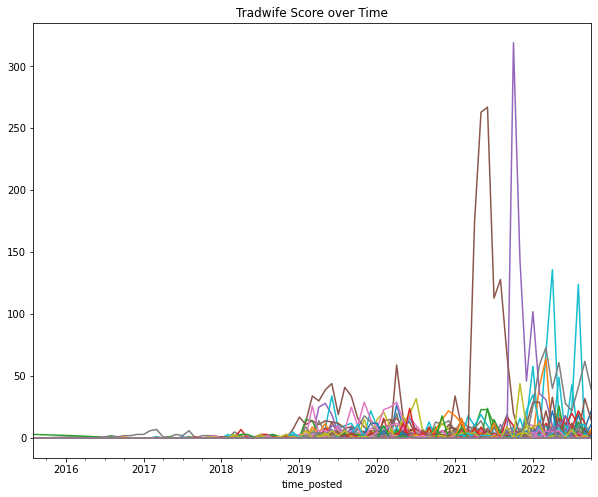

In [12]:
timeseriesdf[relevant_users].plot(figsize=(10,8), legend=False, title="Tradwife Score over Time")


Making monthly graphs, larger time slices are too big to make projection

In [8]:
import networkx as nx
from networkx.algorithms import bipartite

#grabbing all posts from august 2022
augdf = df[(df['time_posted'] > '2022-08-01 00:00:00') & (df['time_posted'] < '2022-08-31 00:00:00')]
print(augdf.head())



                  time_posted                 blog_name             post_id  \
2764  2022-08-18 18:47:26 GMT  perfectmoneygoopdiplomat  692949820125691904   
2765  2022-08-18 00:10:17 GMT  perfectmoneygoopdiplomat  692879535970156544   
2766  2022-08-18 00:09:42 GMT  perfectmoneygoopdiplomat  692879498723606528   
2767  2022-08-16 21:16:31 GMT         fearlessly-aurora  692778006493773824   
2768  2022-08-16 12:23:07 GMT         radicallyfeminine  692744447818088448   

     post_type                                         image_urls  \
2764      text  [https://64.media.tumblr.com/436cdb15327c18af2...   
2765      text  [https://64.media.tumblr.com/379eeb2597e9883a1...   
2766      text  [https://64.media.tumblr.com/c9c66464810e94e95...   
2767      text  [https://64.media.tumblr.com/3af1f001993a48144...   
2768      text  [https://64.media.tumblr.com/4fe6012f73e57200a...   

                                                   tags  \
2764  [cottagecore, cottage aesthetic, tradfem, tra

In [7]:
#making graph
import networkx as nx
from networkx.algorithms import bipartite

def make_bipartite(df):
    B = nx.Graph()
    #getting tradwife scores
    df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)
    tradwifescores = df.groupby(by=["blog_name"])['tradwife_score'].sum()

    for index, row in df.iterrows():
        if row['blog_name'] not in B.nodes():
            B.add_node(row['blog_name'], type = 'user', tradwifescore=tradwifescores[row['blog_name']])
        for tag in row['tags']:
            if '#'+tag not in B.nodes():
                B.add_node('#'+tag, type = 'tag')
            B.add_edge('#'+tag, row['blog_name'])
    print("Is bipartite? "+str(bipartite.is_bipartite(B)))
    print("Num nodes: "+str(len(B.nodes())))
    print("Num edges: "+str(len(B.edges())))
    return B

A = make_bipartite(augdf)

NameError: name 'augdf' is not defined

In [ ]:
#overlap between july and august 2022 users 
#grabbing all posts from july 2022
start_date = '2022-07-01 00:00:00'
end_date = '2022-07-31 00:00:00'
julydf = df[(df['time_posted'] > start_date) & (df['time_posted'] < end_date)]
print(julydf.head())
J = make_bipartite(julydf)

                   time_posted                 blog_name             post_id  \
2704 2022-07-08 14:05:15+00:00  perfectmoneygoopdiplomat  689217591782326272   
2705 2022-07-07 21:39:14+00:00        flowers-and-family  689155557183062016   
2706 2022-07-07 17:31:57+00:00  perfectmoneygoopdiplomat  689139998633721856   
2707 2022-07-07 09:33:29+00:00  perfectmoneygoopdiplomat  689109896633974784   
2708 2022-07-04 12:02:37+00:00   femme-et-traditionnelle  688847488313163776   

     post_type                                         image_urls  \
2704      text  [https://64.media.tumblr.com/2a7e7990f1426376f...   
2705      text  [https://64.media.tumblr.com/3f411d9d47ba29938...   
2706      text  [https://64.media.tumblr.com/8d5a89a80bdb0e89d...   
2707      text  [https://64.media.tumblr.com/fa461fcd798305851...   
2708     photo                                                 []   

                                                   tags  \
2704  [cottagecore, cottage aesthetic, tradfe

C:\Users\melka\AppData\Local\Temp\ipykernel_20668\3080792207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 8717
Num edges: 17959


In [ ]:
print(len(set(J.nodes()).intersection(set(A.nodes()))))

2942


Analyze bridge by making large bipartite network and then grabbing all blogs with large tradwife score, the tags they connect to, and the blogs connected to those tags, then build projection?

In [15]:
nodes_to_keep = []

for node, data in A.nodes(data=True):
    if data["type"]=='user':
        if data["tradwifescore"]>0:
            nodes_to_keep.append(node)
            for tag in A.neighbors(node):
                nodes_to_keep.append(tag)
                for neighbor in A.neighbors(tag):
                    nodes_to_keep.append(neighbor)

nodes_to_remove = set(list(A.nodes())) - set(nodes_to_keep)

A.remove_nodes_from(nodes_to_remove)





In [16]:
#could get list of relevant tags easily from this, just need to be sure we are not only looking at tradwife users
print(len(A.edges()))
print(len(A.nodes()))

5082
1671


In [17]:
#getting projection
user_nodes = {n for n, d in A.nodes(data=True) if d["type"] == "user"}
print("making graph")
W = bipartite.weighted_projected_graph(A, user_nodes) 
print("saving graph")
nx.write_graphml(W, "projection_full.graphml")

making graph
saving graph


Degree distribution and Betweeness Centrality

In [18]:

def plot_degree(G, number_of_bins=50, log_binning=True, base=2):
    """
    Given a graph, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot and
    plot the distribution.
    
    Parameters
    ----------
    degree (nx graph):
        network x graph (undirected)

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool)
        if you are plotting on a log-log axis, then this is useful
    
    base (int):
        log base, defaults to 2
        
    Returns
    -------
    x, y (np.ndarray):
        the support and probability values of the degree distribution
    
    """
    degree = np.array(list(dict(G.degree()).values()))

    # We need to define the support of our distribution
    lower_bound = min(degree)
    upper_bound = max(degree)
    
    # And the bins
    if log_binning:
        log = np.log2 if base == 2 else np.log10
        lower_bound = log(lower_bound) if lower_bound >= 1 else 0.0
        upper_bound = log(upper_bound)
        bins = np.logspace(lower_bound,upper_bound,number_of_bins, base = base)
    else:
        bins = np.linspace(lower_bound,upper_bound,number_of_bins)
    
    # Then we can compute the histogram using numpy
    y, __ = np.histogram(degree, 
                         bins=bins,
                         density=True)
    # Now, we need to compute for each y the value of x
    x = bins[1:] - np.diff(bins)/2.0

    fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

    ax.loglog(x, y,'o', label='degree', alpha=0.8)

    ax.set_xlabel(r"$k$", fontsize=16)
    ax.set_ylabel(r"$P(k)$", fontsize=16)
    ax.set_title("Degree Distribution")

    ax.legend(fontsize=14)
    plt.show()

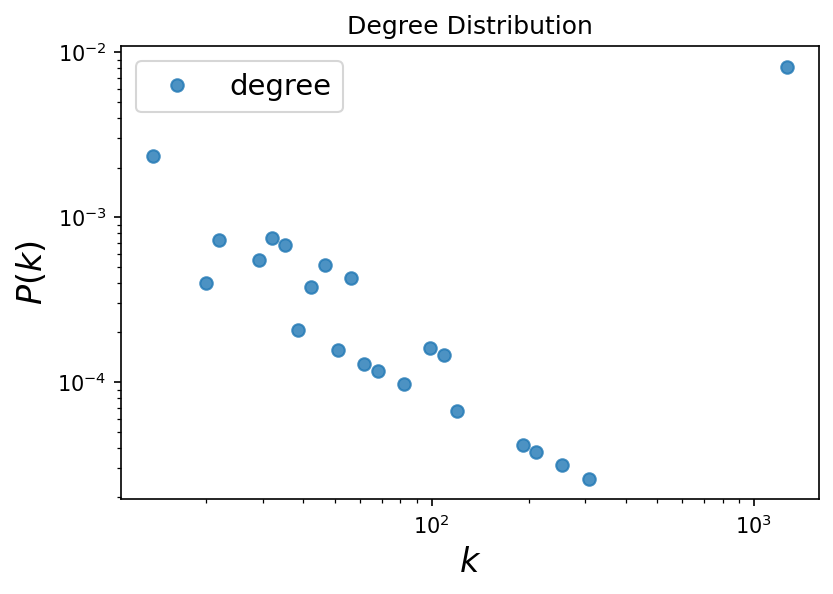

In [47]:
plot_degree(W)


In [ ]:
print(sorted(W.degree, key=lambda x: x[1], reverse=True))

Analyzing bridge tags

In [105]:
#getting important tags
#tag nodes with most amount of edges (used by the most users)
tag_nodes = [x for x,y in A.nodes(data=True) if y['type']=='tag']
degree_tags = A.degree(tag_nodes)
wordclouddata = []
for tag in degree_tags:
    i = 0
    while i<tag[1]:
        wordclouddata.append(tag[0][1:])
        i = i + 1
wordclouddata=' '.join(wordclouddata)

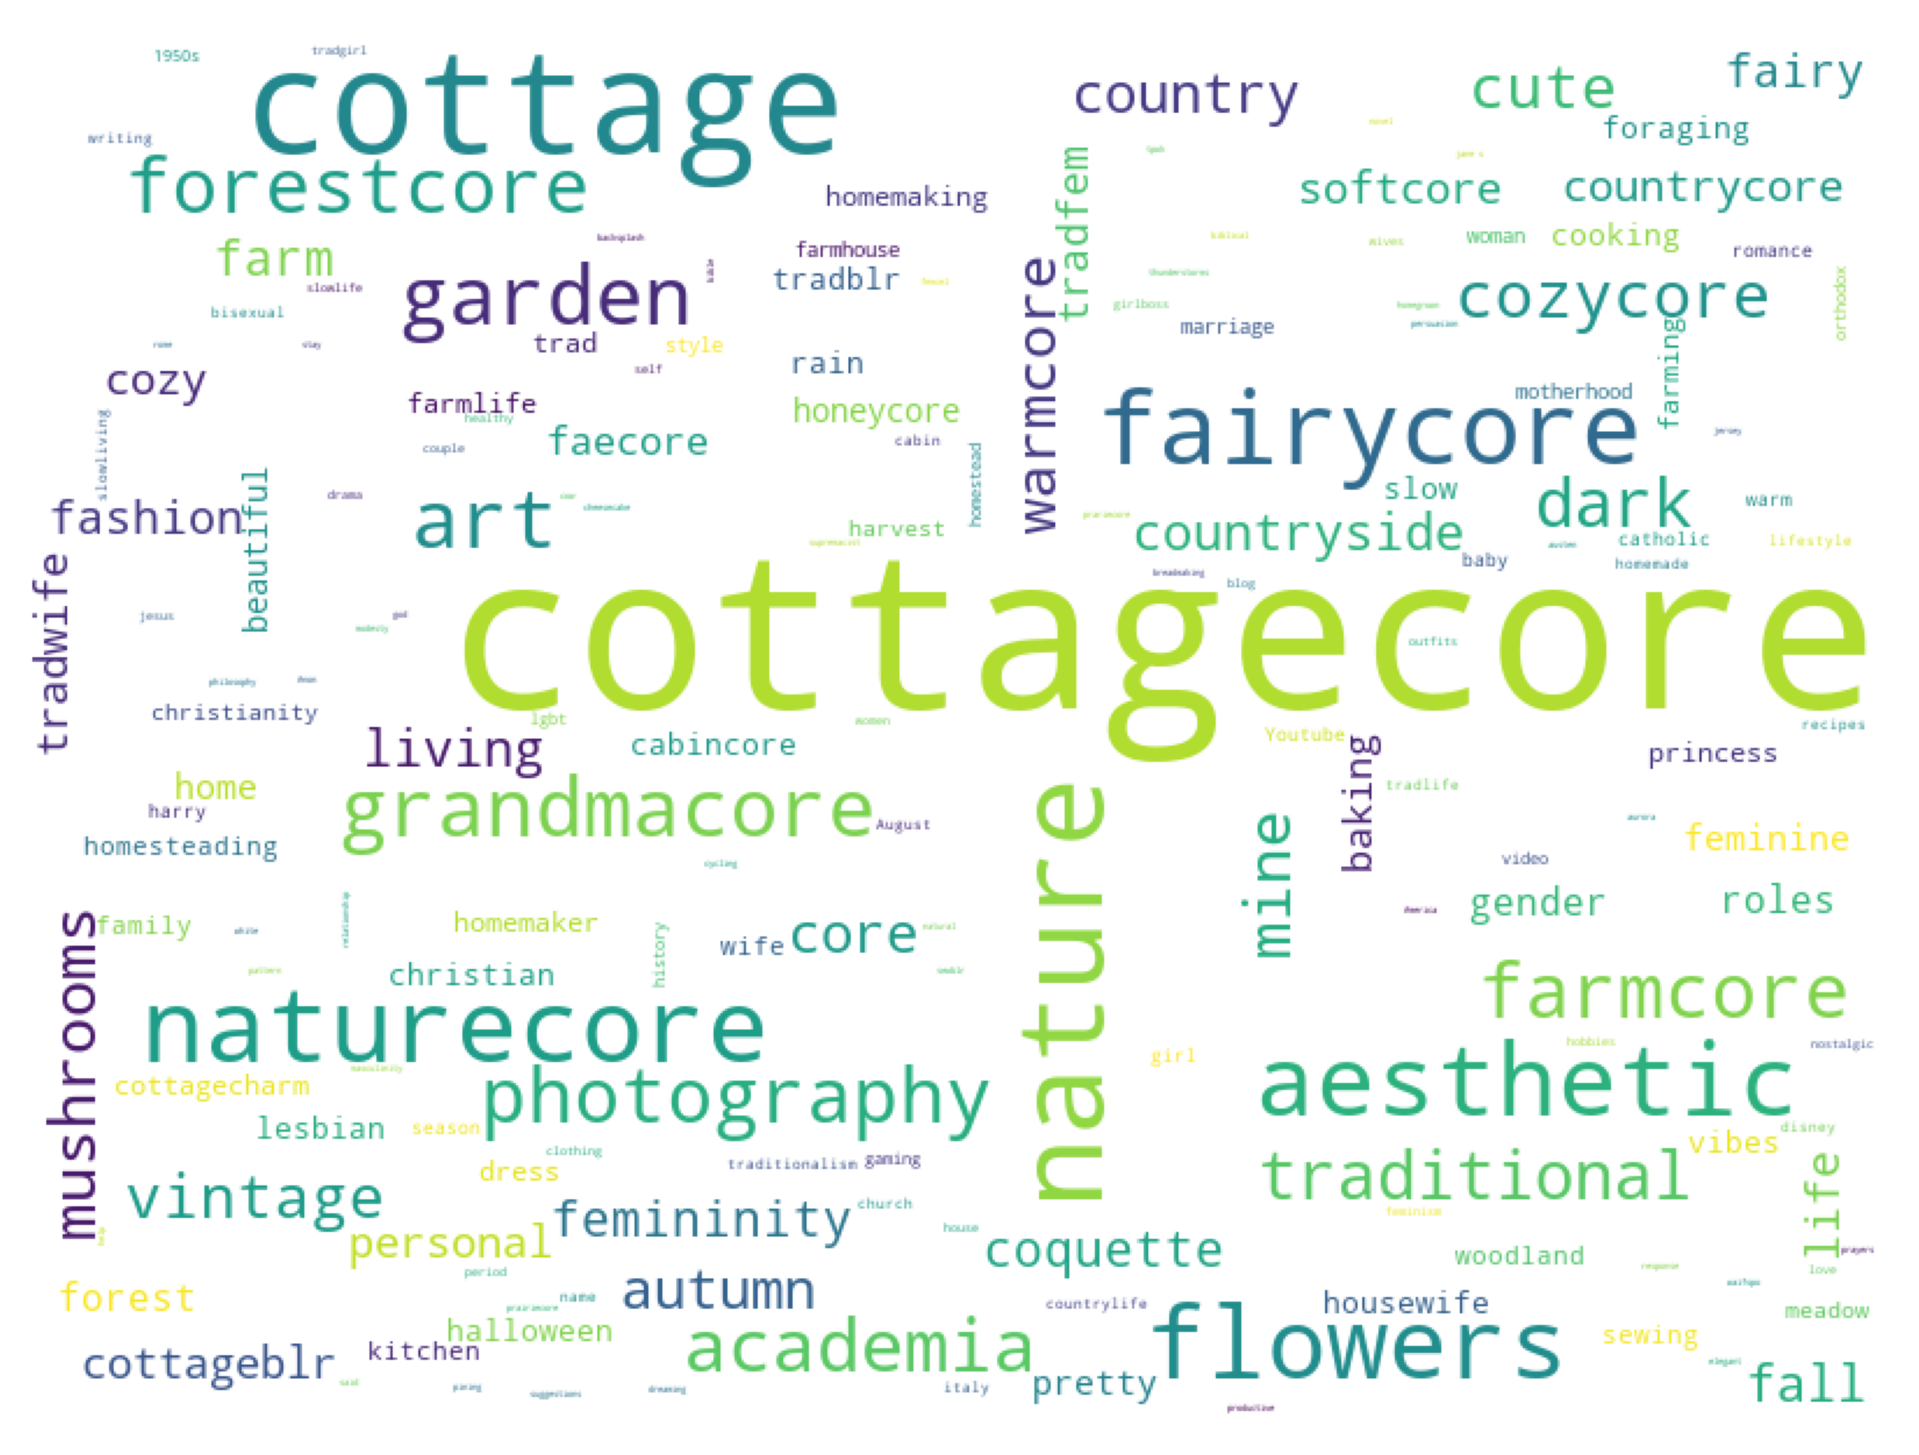

In [114]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=600, background_color='white', collocations=False).generate(wordclouddata)
plt.figure(figsize=(8,8), dpi=300)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Modeling

c:\Users\melka\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='time_posted'>

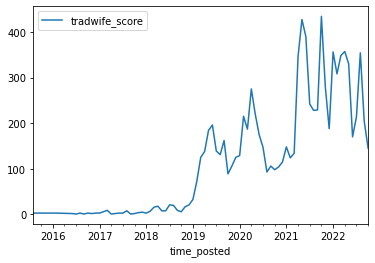

In [10]:
#when does tradwife content begin to be posted? looks like we should look at 2019-2022 posts
import pandas as pd
df['time_posted'] = pd.to_datetime(df.time_posted)
timeseriesdf = df.groupby(df.time_posted.dt.to_period('M')).sum('tradwife_score').reset_index()
timeseriesdf.plot('time_posted', 'tradwife_score')

In [8]:
#constructing this bipartite network 2019-2022
smalldf = df[(df['time_posted'] > '2019-01-01 00:00:00') & (df['time_posted'] < '2022-11-11 00:00:00')]
G = make_bipartite(smalldf)

C:\Users\melka\AppData\Local\Temp\ipykernel_7416\2540636688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 174220
Num edges: 660006


In [62]:
#construct a tree of tradwife nodes, tags, and then cottagecore blogs attached to those tags
tradwife_users = [x for x,y in G.nodes(data=True) if 'tradwifescore' in y and y['tradwifescore']>=1]
T = nx.Graph()
T.add_nodes_from(tradwife_users, type='tradwife', mode = 1)
for tradwife_blog in tradwife_users:
    for tag in G.neighbors(tradwife_blog): #for each tag posted by tradwife user add a node
        if tag not in T.nodes():
            T.add_node(tag, type='tag', mode = 2)
            T.add_edge(tradwife_blog, tag)
        for cottagecore_blog in G.neighbors(tag): #add edges to only cottagecore nodes connected to by these tags
            if cottagecore_blog not in T.nodes():
                T.add_node(cottagecore_blog, type = 'cottagecore', mode = 3)
                T.add_edge(cottagecore_blog, tag)


In [63]:
#saving for visualization
nx.write_graphml(T, "bridge.graphml")

In [65]:
print(len(T.nodes()))
print(len(T.edges()))
print(len([x for x,y in T.nodes(data=True) if y['type']=='cottagecore']))
print(len([x for x,y in T.nodes(data=True) if y['type']=='tradwife']))
print(len([x for x,y in T.nodes(data=True) if y['type']=='tag']))


45253
44505
36767
748
7738


In [21]:
print(len([x for x,y in T.nodes(data=True) if y['type']=='cottagecore'])) #original number of cottagecore blogs connected to tradwife content

36767


In [22]:
tag_nodes = [x for x,y in T.nodes(data=True) if y['type']=='tag']
tag_score = {"tag":tag_nodes, "score":[]}

i = 0

for tag in tag_nodes:
    R = T.copy()
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    tag_score['score'].append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    if i%100==0:
        print(i)
    i = i + 1

0


KeyboardInterrupt: 

In [41]:
print("saving to pickle file...")
df = pd.DataFrame.from_dict(tag_score)
df.to_pickle("tag_score.pkl", compression='infer', protocol=5, storage_options=None)

saving to pickle file...


In [23]:
import pickle
with open('tag_score.pkl', 'rb') as f:
    tag_score_df = pickle.load(f)
print(tag_score_df.head())

                 tag  score
0         #ramblings  36722
1           #tradfem  36767
2              #sahm  36763
3  #stay at home mom  36763
4  #stay at home mum  36767


In [24]:
#converting to percentages and sorting 
tag_score_df["score"]=(36767-tag_score_df["score"])/36767

In [59]:
print(tag_score_df.sort_values("score", ascending=False).head(20))

               tag     score
399   #cottagecore  0.658471
9          #nature  0.176544
10        #flowers  0.064922
7          #baking  0.038350
23        #animals  0.008758
162           #tea  0.007289
6         #cookies  0.006881
8         #cooking  0.006228
2430  #Cottagecore  0.004950
64          #bread  0.003998
11         #floral  0.003862
62       #knitting  0.002992
48       #homemade  0.002285
389     #homestead  0.001469
156          #cake  0.001224
0       #ramblings  0.001224
39         #please  0.001006
163        #teapot  0.000979
271           #jam  0.000734
20     #homemaking  0.000571


In [39]:
#plotting removal of tag nodes in order of tag score, using T
R = T.copy()
x = [0, ]
y = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for tag in tag_score_df.sort_values("score", ascending=False)["tag"]:
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    x.append(i)
    y.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    if i%100==0:
        print(i)



100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700


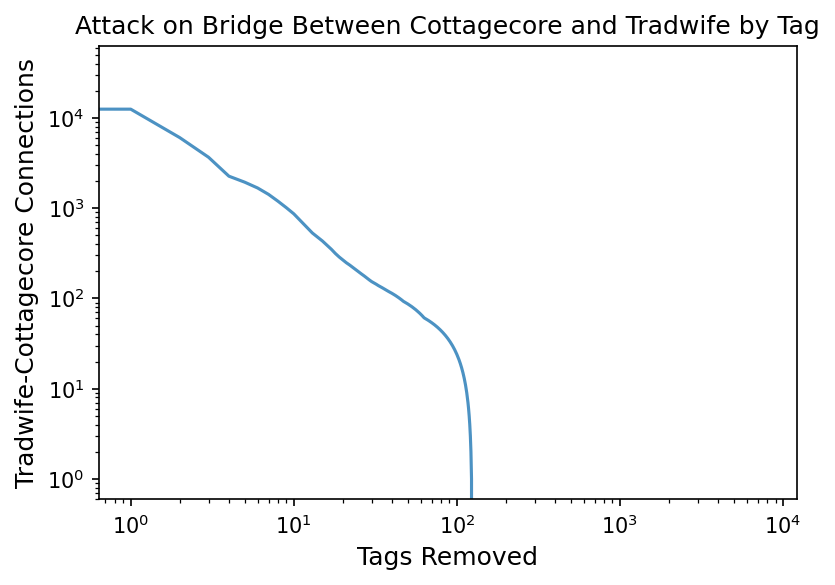

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x, y,'-', alpha=0.8)

ax.set_xlabel("Tags Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife by Tag")

plt.show()

In [ ]:
#trying to remove tags that have to do with tradwives from manual annotation

In [32]:
#saving to excel to examine tags
tag_score_df.to_excel("tags.xlsx")
tradwife_tags = ["#traditional", "#trad", "#traditional femininity", "#sahm", "#stay at home mom", "#modesty", "#Tradwife", "#traditional gender roles", "#Tradfem", "#feminism", "#feminine"]

In [34]:
#plotting removal of tradwife tag nodes in order of tag score, using T
R = T.copy()
x_trad = [0, ]
y_trad = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for tag in tradwife_tags:
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    x_trad.append(i)
    y_trad.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    if i%100==0:
        print(i)


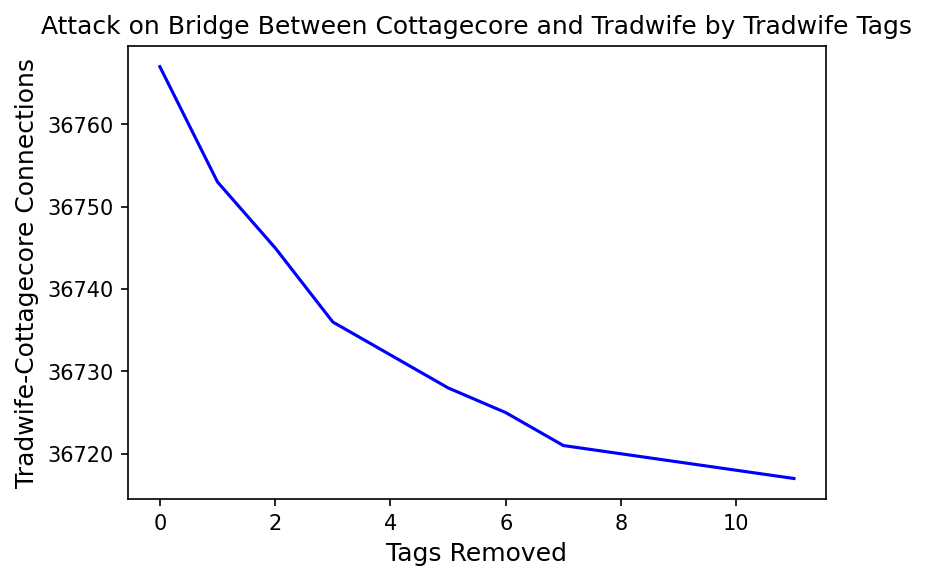

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.plot(x_trad, y_trad, 'b-')

ax.set_xlabel("Tags Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife by Tradwife Tags")

plt.show()

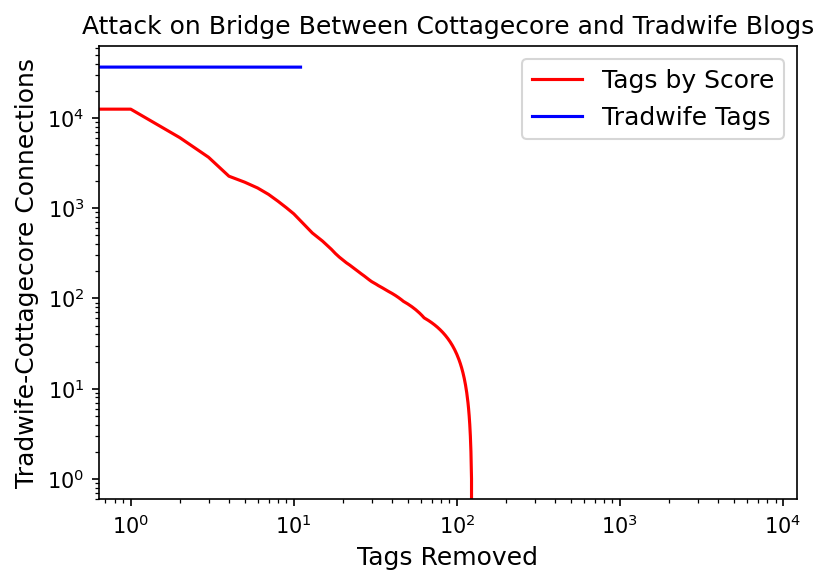

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x, y,'r-', label = "Tags by Score")
ax.loglog(x_trad, y_trad, 'b-', label="Tradwife Tags")

ax.set_xlabel("Tags Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.legend(fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife Blogs")

plt.show()

In [24]:
#removing tradwife users, first getting degree and tradwife score in dict
import pandas as pd
tradwife_blogs = [x for x,y in T.nodes(data=True) if y['type']=='tradwife']
tradwife_dict = {'blog':tradwife_blogs, 'degree':[], 'tradwifescore':[]}
for blog in tradwife_blogs:
    tradwife_dict['degree'].append(T.degree(blog))
    tradwife_dict['tradwifescore'].append(G.nodes[blog]["tradwifescore"])
tradwife_df = pd.DataFrame.from_dict(tradwife_dict)


In [59]:
#removing tradwife blogs in order of degree
R = T.copy()
x_deg = [0, ]
y_deg = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for blog in tradwife_df.sort_values("degree", ascending=False)["blog"]:
    #get all tags potentially affected by this blog removal
    try: 
        tags = R.neighbors(blog)
        R.remove_node(blog)
        #get all tags that now do not connect to any tradfem users and remove them
        j = 0
        for tag in tags:
            neighbordata = [(k, dict(R.nodes(data=True))[k]) for k in R.neighbors(tag)]
            if len([x for x,y in neighbordata if y['type']=='tradwife'])==0: #if tag no longer has any tradwife neighbors
                R.remove_node(tag)
        R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
        x_deg.append(i)
        y_deg.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    except nx.NetworkXError: #blog has already been removed
        x_deg.append(i)
        y_deg.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    print("step"+str(i))
    # if i%100==0:
    #     print(i)

#removing blogs in order of score
R = T.copy()
x_tradwife = [0, ]
y_tradwife = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for blog in tradwife_df.sort_values("tradwifescore", ascending=False)["blog"]:
    #get all tags potentially affected by this blog removal
    try: 
        tags = R.neighbors(blog)
        R.remove_node(blog)
        #get all tags that now do not connect to any tradfem users and remove them
        for tag in tags:
            neighbordata = [(k, dict(R.nodes(data=True))[k]) for k in R.neighbors(tag)]
            if len([x for x,y in neighbordata if y['type']=='tradwife'])==0: #if tag no longer has any tradwife neighbors
                R.remove_node(tag)
        R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
        x_tradwife.append(i)
        y_tradwife.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    except nx.NetworkXError: #blog has already been removed
        x_tradwife.append(i)
        y_tradwife.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    print("step"+str(i))
    # if i%100==0:
    #     print(i)

step2
step3
step4
step5
step6
step7
step8
step9
step10
step11
step12
step13
step14
step15
step16
step17
step18
step19
step20
step21
step22
step23
step24
step25
step26
step27
step28
step29
step30
step31
step32
step33
step34
step35
step36
step37
step38
step39
step40
step41
step42
step43
step44
step45
step46
step47
step48
step49
step50
step51
step52
step53
step54
step55
step56
step57
step58
step59
step60
step61
step62
step63
step64
step65
step66
step67
step68
step69
step70
step71
step72
step73
step74
step75
step76
step77
step78
step79
step80
step81
step82
step83
step84
step85
step86
step87
step88
step89
step90
step91
step92
step93
step94
step95
step96
step97
step98
step99
step100
step101
step102
step103
step104
step105
step106
step107
step108
step109
step110
step111
step112
step113
step114
step115
step116
step117
step118
step119
step120
step121
step122
step123
step124
step125
step126
step127
step128
step129
step130
step131
step132
step133
step134
step135
step136
step137
step138
step139
st

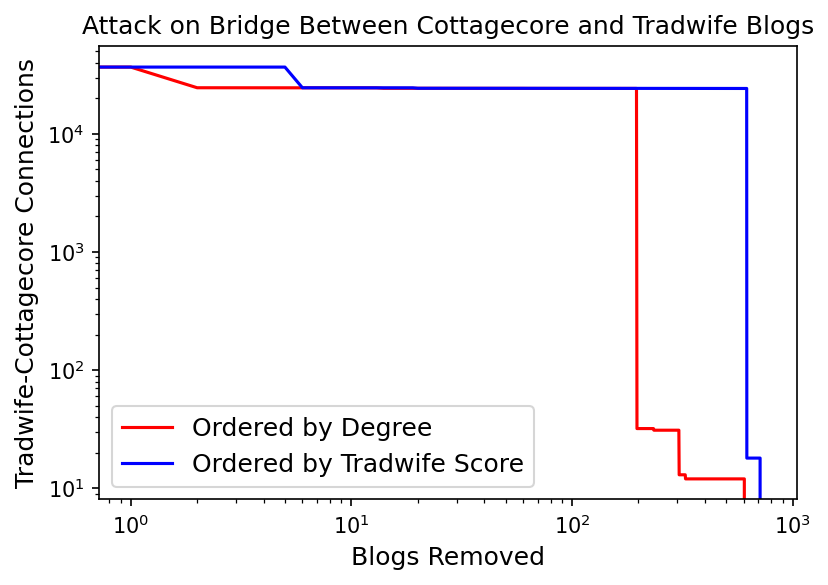

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x_deg, y_deg,'r-', label = "Ordered by Degree")
ax.loglog(x_tradwife, y_tradwife, 'b-', label="Ordered by Tradwife Score")

ax.set_xlabel("Blogs Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.legend(fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife Blogs")

plt.show()

Link Prediction

In [9]:
#getting two bipartite networks
df2020_1 = df[(df['time_posted'] > '2020-01-01 00:00:00') & (df['time_posted'] < '2020-06-01 00:00:00')]
G_2020_1 = make_bipartite(df2020_1)
df2020_2 = df[(df['time_posted'] > '2020-06-01 00:00:00') & (df['time_posted'] < '2021-01-01 00:00:00')]
G_2020_2 = make_bipartite(df2020_2)

C:\Users\melka\AppData\Local\Temp\ipykernel_7416\2540636688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 37329
Num edges: 121358


C:\Users\melka\AppData\Local\Temp\ipykernel_7416\2540636688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 56644
Num edges: 177010


In [2]:
# lp_l3 <- function(g){
#   non_edges <- get_non_edges(g)
#   m <- as_adjacency_matrix(g, names = FALSE)
#   # Degree-normalise the adjacency matrix
#   D <- Matrix(diag(1/sqrt(degree(g))))
#   m <- (D %*% m) %*% D
#   # Compute the L3 score
#   l3 <- (m %*% m) %*% m
#   prediction <- tibble(nodeA = non_edges[, 1], nodeB = non_edges[, 2],
#                        scr = l3[non_edges]) %>%
#     arrange(desc(scr))
#   return(prediction)
# }
import math
import scipy
def lp_l3(G, threshold):
    nodelist = list(dict(G.degree()).keys())
    m = nx.to_scipy_sparse_array(G, nodelist=nodelist, format = 'csr') #ordering node by degree dict for normalization
    #degree normalize adjacency matrix
    D = scipy.sparse.diags([1/math.sqrt(val) for val in list(dict(G.degree()).values())], 0, format="csr")
    m = (D@m)@D
    l3 = (m@m)@m
    print("finding indexes above threshold")
    p = l3 > threshold
    row, col, value = scipy.sparse.find(p)
    print("packing up values")
    edgedict = {(nodelist[i], nodelist[j]):l3[i,j] for i, j in zip(row, col)}
    return edgedict




In [11]:
predicted_edges = lp_l3(G_2020_1, 0.2)
#unable to output data for all edges (too large), maybe only output score for edges that are actually present in the next graph? 
#also try doing smaller time intervals, maybe 3-6 months

finding indexes above threshold
packing up values


In [12]:
#number of accurately predicted edges 
true_edges = set(G_2020_2.edges())
predicted_edges = set(predicted_edges.keys())
correctly_predicted_edges = true_edges.intersection(predicted_edges)

In [14]:
print(len(predicted_edges))
print(len(correctly_predicted_edges))

3400
21
